In [2]:
from intake import open_catalog
import datetime
import numpy as np
import pandas as pd
import scipy.io
from scipy import interpolate
import gsw
import gcsfs
import xarray as xr
import rclv
import os
from copy import deepcopy
from skimage import measure
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
# load ssh eddy information
df = pd.read_pickle('eddy_data.pkl')
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.0,45.0,4.944328e+10,0.083280,-0.650595,-0.000009,80266.753659,-0.087273,0.035749,-1.0,0.357019,0.050497,123.875,20.125
1,2.0,31.0,1.041958e+10,0.009457,0.230652,0.000003,65940.386649,-0.050919,-0.041515,1.0,0.101414,0.003837,115.875,11.125
2,3.0,48.0,4.940120e+09,0.009673,0.165413,0.000006,52602.179429,-0.019697,-0.006703,1.0,0.145094,0.006766,113.375,11.625
3,4.0,50.0,2.289068e+10,0.020630,-0.200860,-0.000004,85517.729432,-0.044308,-0.019305,-1.0,0.173021,0.010500,114.375,10.375
4,5.0,43.0,1.113819e+10,0.023152,0.269953,0.000005,59882.550288,-0.161588,-0.052377,1.0,0.151511,0.008405,118.125,20.125


In [9]:
dura = df.loc[:, 1].values
rad = df.loc[:, 6].values

amp = df.loc[:, 3].values
damp = df.loc[:, 4].values

cyc = df.loc[:, 9].values
vort = df.loc[:, 5].values

spx = df.loc[:, 7].values
spy = df.loc[:, 8].values

edsp = df.loc[:, 10].values
ke = df.loc[:, 10].values

lon = df.loc[:, 12].values
lat = df.loc[:, 13].values

In [10]:
leak_data = np.zeros((2394, 22))
leak_data[:, :] = np.NaN
intru_data = np.zeros((2394, 22))
intru_data[:, :] = np.NaN

leak_norm = np.zeros((2394, 30))
leak_norm[:, :] = np.NaN
intru_norm = np.zeros((2394, 30))
intru_norm[:, :] = np.NaN

leak_array = np.zeros((2394, 1))
leak_array[:] = np.NaN

In [11]:
df_leak = pd.DataFrame(leak_data)
df_intru = pd.DataFrame(intru_data)

df_leak_norm = pd.DataFrame(leak_norm)
df_intru_norm = pd.DataFrame(intru_norm)

In [12]:
cal_var = np.load('cal_var.npy')
eddy_norm_t = np.linspace(0, 1, 30)

for i in np.arange(2394):
    fn1 = './pkl/leak_data_' + str(i).zfill(4) + '.pkl'
    fn2 = './pkl/intru_data_' + str(i).zfill(4) + '.pkl'
    if os.path.exists(fn1):
        df_tmp1 = pd.read_pickle(fn1)
        df_tmp2 = pd.read_pickle(fn2)
        df_leak.iloc[i, :] = df_tmp1.iloc[0]
        df_intru.iloc[i, :] = df_tmp2.iloc[0]
        
        idtmp = int(cal_var[i, 2]) + 4
        
        var1 = (df_tmp1.iloc[0, 3:idtmp] / df_tmp1.iloc[0, 3]).to_numpy()
        var_t1 = (cal_var[i, 0] - cal_var[i, 1]) / cal_var[i, 0]
        var_t2 = (cal_var[i, 0] - cal_var[i, 1] + cal_var[i, 2] * 10) / cal_var[i, 0]
        var_tt = np.linspace(var_t1, var_t2, var1.shape[0])
        
        if var_tt.shape[0] > 1:
            fun1 = interpolate.interp1d(var_tt, var1, bounds_error=False)
            df_leak_norm.loc[i, :] = fun1(eddy_norm_t);
            
            tmp = df_leak_norm.loc[i, :].values
            tmp = tmp[~np.isnan(tmp)]
            
            if tmp.shape[0] > 1:
                leak_array[i] = tmp[-1]
        #var2 = cal
        #time_var1 = cal_var[i]

In [19]:
#total num 
eddyid1 = np.where((lon<122) & (lon>116) & (lat<23) & (lat>18) & (leak_array[:,0]>0))[0]
eddyid1.shape

(392,)

In [27]:
#total num 
eddyid1 = np.where((lon<115) & (lon>105) & (lat<15) & (lat>10) & (leak_array[:,0]>0))[0]
eddyid1.shape

(240,)

In [28]:
leak_var1 = np.zeros((2394, 50, 50))
leak_var1[:, :] = np.nan
leak_var2 = np.zeros((2394, 50, 50))
leak_var2[:, :] = np.nan

In [29]:
for i in np.arange(2394):
    fn1 = './array_data/leak_' + str(i).zfill(4) + '.npy'
    if os.path.exists(fn1):
        
        var_data = np.load(fn1)
        leak_var1[i, :, :] = var_data[0, :, :] / var_data[0, :, :].sum()
        leak_var2[i, :, :] = var_data[1, :, :] / var_data[0, :, :].sum()

#id = df[df.cyc<0].index.tolist()
leak_day0 = np.nanmean(leak_var1[eddyid1, :, :], axis=0)
leak_day1 = np.nanmean(leak_var2[eddyid1, :, :], axis=0)

<ipython-input-30-dfe4e9a03319>:8: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(xx, yy, np.log10(100*leak_day0), levels=np.arange(-3, 0.01, 0.2), vmin=-3, vmax=0, cmap='Spectral_r', extend='max')
<ipython-input-30-dfe4e9a03319>:13: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(xx, yy, np.log10(100*leak_day1), levels=np.arange(-3, 0.01, 0.2), vmin=-3, vmax=0, cmap='Spectral_r', extend='max')


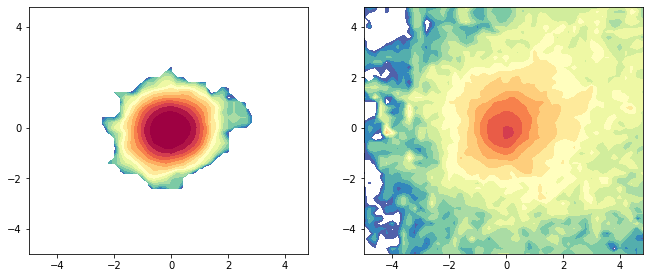

In [30]:
xx, yy = np.mgrid[-5:5:0.2, -5:5:0.2]
lev = np.arange(0, 0.01001, 0.001)

fig = plt.figure(figsize=(11, 10))

plt.subplot(221)

plt.contourf(xx, yy, np.log10(100*leak_day0), levels=np.arange(-3, 0.01, 0.2), vmin=-3, vmax=0, cmap='Spectral_r', extend='max')
#plt.colorbar()

plt.subplot(222)

plt.contourf(xx, yy, np.log10(100*leak_day1), levels=np.arange(-3, 0.01, 0.2), vmin=-3, vmax=0, cmap='Spectral_r', extend='max')
#plt.colorbar()

/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


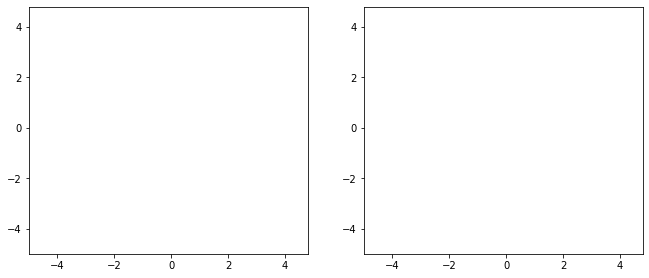

In [26]:
xx, yy = np.mgrid[-5:5:0.2, -5:5:0.2]
lev = np.arange(0, 0.01001, 0.001)

fig = plt.figure(figsize=(11, 10))

plt.subplot(221)

plt.contourf(xx, yy, np.log10(100*leak_day0), levels=np.arange(-3, 0.01, 0.2), vmin=-3, vmax=0, cmap='Spectral_r', extend='max')
#plt.colorbar()

plt.subplot(222)

plt.contourf(xx, yy, np.log10(100*leak_day1), levels=np.arange(-3, 0.01, 0.2), vmin=-3, vmax=0, cmap='Spectral_r', extend='max')
#plt.colorbar()